In [16]:
from datetime import datetime
import requests
import time
import pandas as pd

_BASE_UM_URL = 'https://fapi.binance.com'
_BASE_BYBIT_URL = 'https://api.bybit.com'



def download_funding_rates_binance(symbol: str, start: datetime, end: datetime):
    url = f'{_BASE_UM_URL}/fapi/v1/fundingRate'
    start_timestamp = int(start.timestamp()) * 1000
    end_timestamp = int(end.timestamp()) * 1000

    funding_rates = []
    while start_timestamp < end_timestamp:
        try:
            response = requests.get(url, params={
                'symbol': symbol,
                'startTime': start_timestamp,
                'endTime': end_timestamp,
                'limit': 1000
            })
            response.raise_for_status()
            data = response.json()
            if not isinstance(data, list) or not data:
                break
            funding_rates.extend(data)
            start_timestamp = data[-1].get('fundingTime', start_timestamp) + 1
            time.sleep(0.5)
        except requests.RequestException as e:
            print(f"Error fetching Binance funding rates: {e}")
            break

    return funding_rates


def download_funding_rates_bybit(symbol: str, start: datetime, end: datetime):
    url = f'{_BASE_BYBIT_URL}/v5/market/funding/history'
    start_timestamp = int(start.timestamp()) * 1000  # Bybit uses milliseconds
    end_timestamp = int(end.timestamp()) * 1000

    funding_rates = []
    while start_timestamp < end_timestamp:
        try:
            response = requests.get(url, params={
                'symbol': symbol,
                'category': 'linear',  # Market category (e.g., linear perpetual contracts)
                'startTime': start_timestamp,
                'endTime': end_timestamp,
                'limit': 200
            })
            response.raise_for_status()
            result = response.json().get('result', {}).get('list', [])
            if not result:
                print("No more data available in the specified time range.")
                break
            funding_rates.extend(result)
            start_timestamp = int(result[-1]['fundingRateTimestamp']) + 1
            print(f"Fetched Bybit funding rate data up to {pd.to_datetime(start_timestamp, unit='ms')}")
            time.sleep(0.5)  # Rate limit
        except requests.RequestException as e:
            print(f"Error fetching Bybit funding rates: {e}")
            break

    return funding_rates




def save_to_csv(df, filename):
    try:
        df.to_csv(filename)
        print(f"Data saved to {filename}")
    except Exception as e:
        print(f"Error saving to file {filename}: {e}")


if __name__ == '__main__':
    start = datetime(2024, 11, 1)
    end = datetime(2024, 12, 1)

    # Binance
    symbol_binance = 'BTCUSDT'
    funding_rates_binance = download_funding_rates_binance(symbol_binance, start, end)
    if funding_rates_binance:
        df_binance = pd.DataFrame(funding_rates_binance)
        if 'fundingTime' in df_binance.columns:
            df_binance['time'] = pd.to_datetime(df_binance['fundingTime'], unit='ms')
            df_binance.set_index('time', inplace=True)
            print(df_binance.head())
            save_to_csv(df_binance, '/tmp/binance_funding_rates.csv')

    # Bybit
    symbol_bybit = 'BTCUSDT'
    funding_rates_bybit = download_funding_rates_bybit(symbol_bybit, start, end)
    if funding_rates_bybit:
        df_bybit = pd.DataFrame(funding_rates_bybit)
        if 'fundingRateTimestamp' in df_bybit.columns:
            df_bybit['time'] = pd.to_datetime(df_bybit['fundingRateTimestamp'], unit='ms')
            df_bybit.set_index('time', inplace=True)
            print(df_bybit.head())
            save_to_csv(df_bybit, '/tmp/bybit_funding_rates.csv')



                      symbol    fundingTime fundingRate       markPrice
time                                                                   
2024-11-01 08:00:00  BTCUSDT  1730448000000  0.00010000  69300.16876596
2024-11-01 16:00:00  BTCUSDT  1730476800000  0.00010000  69380.64255319
2024-11-02 00:00:00  BTCUSDT  1730505600000  0.00010000  69496.19465248
2024-11-02 08:00:00  BTCUSDT  1730534400000  0.00010000  69813.99829787
2024-11-02 16:00:00  BTCUSDT  1730563200000  0.00010000  69396.79744681
Data saved to /tmp/binance_funding_rates.csv
Fetched Bybit funding rate data up to 2024-11-01 08:00:00.001000
Fetched Bybit funding rate data up to 2024-11-01 16:00:00.001000
Fetched Bybit funding rate data up to 2024-11-02 00:00:00.001000
Fetched Bybit funding rate data up to 2024-11-02 08:00:00.001000
Fetched Bybit funding rate data up to 2024-11-02 16:00:00.001000
Fetched Bybit funding rate data up to 2024-11-03 00:00:00.001000
Fetched Bybit funding rate data up to 2024-11-03 08:00:00.001

/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_6885/2114067609.py:101: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_bybit['time'] = pd.to_datetime(df_bybit['fundingRateTimestamp'], unit='ms')


In [1]:
%pip install ratelimit

Note: you may need to restart the kernel to use updated packages.


In [3]:
from datetime import datetime, timedelta
import requests
import time
import pandas as pd
import concurrent.futures
from ratelimit import limits, sleep_and_retry

class DataCollector:
    # Rate limits
    BINANCE_CALLS = 1200  # calls per minute
    BYBIT_CALLS = 600     # calls per minute
    
    _BASE_BINANCE_URLS = {
        'spot': 'https://api.binance.com/api/v3/klines',
        'um': 'https://fapi.binance.com/fapi/v1/klines',
        'cm': 'https://dapi.binance.com/dapi/v1/klines'
    }
    _BASE_BYBIT_URL = 'https://api.bybit.com/v5/market/kline'
    
    @staticmethod
    def calculate_basis(binance_spot, binance_futures, bybit_spot, bybit_futures):
        """
        Calculate the basis for Binance and Bybit spot and futures prices.
        
        Parameters:
        -----------
        binance_spot : pd.DataFrame
            Binance spot price data with timestamp index and 'close' column
        binance_futures : pd.DataFrame
            Binance futures price data with timestamp index and 'close' column
        bybit_spot : pd.DataFrame
            Bybit spot price data with timestamp index and 'close' column
        bybit_futures : pd.DataFrame
            Bybit futures price data with timestamp index and 'close' column
            
        Returns:
        --------
        tuple(pd.DataFrame, pd.DataFrame)
            Two DataFrames containing basis calculations for Binance and Bybit
        """
        # Calculate Binance basis
        binance = pd.merge(
            binance_spot, 
            binance_futures, 
            left_index=True, 
            right_index=True, 
            suffixes=('_spot', '_futures')
        )
        binance['basis'] = binance['close_futures'] - binance['close_spot']
        binance['basis_percent'] = (binance['basis'] / binance['close_spot']) * 100

        # Calculate Bybit basis
        bybit = pd.merge(
            bybit_spot, 
            bybit_futures, 
            left_index=True, 
            right_index=True, 
            suffixes=('_spot', '_futures')
        )
        bybit['basis'] = bybit['close_futures'] - bybit['close_spot']
        bybit['basis_percent'] = (bybit['basis'] / bybit['close_spot']) * 100

        return binance, bybit

    # [Previous methods remain the same: _binance_request, _bybit_request, 
    #  download_binance_bars, download_bybit_bars]
    @staticmethod
    @sleep_and_retry
    @limits(calls=BINANCE_CALLS, period=60)
    def _binance_request(url, params):
        """Rate-limited request to Binance"""
        response = requests.get(url, params=params)
        if response.status_code != 200:
            raise ValueError(f"Error: {response.status_code}, {response.content}")
        return response.json()
    
    @staticmethod
    @sleep_and_retry
    @limits(calls=BYBIT_CALLS, period=60)
    def _bybit_request(url, params):
        """Rate-limited request to Bybit"""
        response = requests.get(url, params=params)
        if response.status_code != 200:
            raise ValueError(f"Error: {response.status_code}, {response.content}")
        return response.json()['result']['list']

    @staticmethod
    def download_binance_bars(product: str, timeframe: str, symbol: str, start: datetime, end: datetime):
        """Download historical bars from Binance with optimized batch processing"""
        if product not in DataCollector._BASE_BINANCE_URLS:
            raise ValueError(f"Invalid Binance product: {product}")
        url = DataCollector._BASE_BINANCE_URLS[product]

        # Calculate time chunks for parallel processing
        chunk_size = timedelta(days=2)  # Process 2 days at a time
        current_start = start
        chunks = []
        
        while current_start < end:
            chunk_end = min(current_start + chunk_size, end)
            chunks.append((current_start, chunk_end))
            current_start = chunk_end

        bars = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            futures = []
            for chunk_start, chunk_end in chunks:
                params = {
                    'symbol': symbol,
                    'interval': timeframe,
                    'startTime': int(chunk_start.timestamp() * 1000),
                    'endTime': int(chunk_end.timestamp() * 1000) - 1,
                    'limit': 1000
                }
                futures.append(executor.submit(DataCollector._binance_request, url, params))
            
            for future in concurrent.futures.as_completed(futures):
                try:
                    chunk_bars = future.result()
                    bars.extend(chunk_bars)
                except Exception as e:
                    print(f"Error downloading chunk: {str(e)}")

        df = pd.DataFrame(bars, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume',
                                       'close_time', 'quote_asset_volume', 'trades',
                                       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['close'] = df['close'].astype(float)
        return df[['timestamp', 'close']].set_index('timestamp')

    @staticmethod
    def download_bybit_bars(product: str, timeframe: str, symbol: str, start: datetime, end: datetime):
        """Download historical bars from Bybit with optimized batch processing"""
        url = DataCollector._BASE_BYBIT_URL
        
        # Calculate time chunks for parallel processing
        chunk_size = timedelta(days=1)  # Process 1 day at a time (Bybit has stricter limits)
        current_start = start
        chunks = []
        
        while current_start < end:
            chunk_end = min(current_start + chunk_size, end)
            chunks.append((current_start, chunk_end))
            current_start = chunk_end

        bars = []
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = []
            for chunk_start, chunk_end in chunks:
                params = {
                    'category': product,
                    'symbol': symbol,
                    'interval': timeframe,
                    'start': int(chunk_start.timestamp() * 1000),
                    'end': int(chunk_end.timestamp() * 1000) - 1,
                    'limit': 200
                }
                futures.append(executor.submit(DataCollector._bybit_request, url, params))
            
            for future in concurrent.futures.as_completed(futures):
                try:
                    chunk_bars = future.result()
                    bars.extend(chunk_bars)
                except Exception as e:
                    print(f"Error downloading chunk: {str(e)}")

        df = pd.DataFrame(bars, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'turnover'])
        df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close'] = df['close'].astype(float)
        return df[['timestamp', 'close']].set_index('timestamp')

def main():
    print("Starting data collection...")
    start_time = time.time()
    
    # Define the date range
    start = datetime(2024, 11, 1)
    end = datetime(2024, 12, 1)

    # Define the tasks
    tasks = [
        ('binance_spot', ('spot', '1h', 'BTCUSDT', start, end)),
        ('binance_futures', ('um', '1h', 'BTCUSDT', start, end)),
        ('bybit_spot', ('spot', '60', 'BTCUSDT', start, end)),
        ('bybit_futures', ('linear', '60', 'BTCUSDT', start, end))
    ]

    results = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = {
            name: executor.submit(
                DataCollector.download_binance_bars if name.startswith('binance') 
                else DataCollector.download_bybit_bars, 
                *args
            )
            for name, args in tasks
        }
        
        for name, future in futures.items():
            try:
                print(f"Downloading {name}...")
                results[name] = future.result()
                print(f"Completed {name}")
            except Exception as e:
                print(f"Error downloading {name}: {str(e)}")
                raise

    # Calculate and save basis
    print("Calculating basis...")
    binance_basis, bybit_basis = DataCollector.calculate_basis(
        results['binance_spot'],
        results['binance_futures'],
        results['bybit_spot'],
        results['bybit_futures']
    )

    binance_basis.to_csv('/tmp/binance_basis.csv')
    bybit_basis.to_csv('/tmp/bybit_basis.csv')
    
    elapsed_time = time.time() - start_time
    print(f"Data collection completed in {elapsed_time:.2f} seconds")

if __name__ == '__main__':
    main()

Starting data collection...
Completed binance_spot
Completed binance_futures


/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_10969/728915850.py:168: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms')
/var/folders/24/c149zfj1773bd25lqq7vdl_w0000gn/T/ipykernel_10969/728915850.py:168: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['open_time'], unit='ms')


Completed bybit_spot
Completed bybit_futures
Calculating basis...
Data collection completed in 16.77 seconds


In [4]:
# Load the data
binance_data = pd.read_csv('/tmp/binance_basis.csv')
bybit_data = pd.read_csv('/tmp/bybit_basis.csv')

# Display the first few rows of each
print("Binance Basis Data:")
print(binance_data.head())
print("\nBybit Basis Data:")
print(bybit_data.head())

Binance Basis Data:
             timestamp  close_spot  close_futures  basis  basis_percent
0  2024-11-09 06:00:00    76510.00        76493.5 -16.50      -0.021566
1  2024-11-09 07:00:00    76529.08        76523.9  -5.18      -0.006769
2  2024-11-09 08:00:00    76539.99        76540.0   0.01       0.000013
3  2024-11-09 09:00:00    76554.00        76545.2  -8.80      -0.011495
4  2024-11-09 10:00:00    76468.01        76451.4 -16.61      -0.021722

Bybit Basis Data:
             timestamp  close_spot  close_futures  basis  basis_percent
0  2024-11-04 05:00:00    68819.32        68810.1  -9.22      -0.013397
1  2024-11-04 04:00:00    69151.89        69139.8 -12.09      -0.017483
2  2024-11-04 03:00:00    69047.17        69037.0 -10.17      -0.014729
3  2024-11-04 02:00:00    69297.61        69289.1  -8.51      -0.012280
4  2024-11-04 01:00:00    68972.78        68958.8 -13.98      -0.020269


In [3]:
import pandas as pd
import numpy as np

class FeeAnalyzer:
    def __init__(self):
        # Binance fee structure (with BNB discount)
        self.binance_fees = {
            'spot': {
                'maker': {
                    'VIP0': 0.001 * 0.75,  # 0.1% * 0.75 (BNB discount)
                    'VIP4': 0.0005 * 0.75,  # 0.05% * 0.75
                    'VIP9': 0.0 * 0.75      # 0% * 0.75
                },
                'taker': {
                    'VIP0': 0.001 * 0.75,   # 0.1% * 0.75
                    'VIP4': 0.0008 * 0.75,  # 0.08% * 0.75
                    'VIP9': 0.0003 * 0.75   # 0.03% * 0.75
                }
            },
            'futures': {
                'maker': {
                    'VIP0': 0.0002 * 0.9,   # 0.02% * 0.9 (BNB discount)
                    'VIP4': 0.0001 * 0.9,   # 0.01% * 0.9
                    'VIP9': 0.0 * 0.9       # 0% * 0.9
                },
                'taker': {
                    'VIP0': 0.0004 * 0.9,   # 0.04% * 0.9
                    'VIP4': 0.0003 * 0.9,   # 0.03% * 0.9
                    'VIP9': 0.00015 * 0.9   # 0.015% * 0.9
                }
            }
        }
        
        # Bybit fee structure
        self.bybit_fees = {
            'spot': {
                'maker': {
                    'Normal': 0.001,    # 0.1%
                    'VIP2': 0.0008,     # 0.08%
                    'VIP3': 0.0007      # 0.07%
                },
                'taker': {
                    'Normal': 0.001,    # 0.1%
                    'VIP2': 0.001,      # 0.1%
                    'VIP3': 0.001       # 0.1%
                }
            },
            'futures': {
                'maker': {
                    'Normal': 0.0001,   # 0.01%
                    'VIP2': 0.00008,    # 0.008%
                    'VIP3': 0.00007     # 0.007%
                },
                'taker': {
                    'Normal': 0.0006,   # 0.06%
                    'VIP2': 0.0005,     # 0.05%
                    'VIP3': 0.00045     # 0.045%
                }
            }
        }

    def calculate_costs(self, position_size, binance_tier='VIP4', bybit_tier='VIP2', 
                       use_maker_orders=True):
        """Calculate total transaction costs for different execution strategies"""
        
        strategies = []
        
        # Strategy 1: All taker orders
        binance_taker_cost = (
            self.binance_fees['spot']['taker'][binance_tier] + 
            self.binance_fees['futures']['taker'][binance_tier]
        ) * position_size
        
        bybit_taker_cost = (
            self.bybit_fees['spot']['taker'][bybit_tier] + 
            self.bybit_fees['futures']['taker'][bybit_tier]
        ) * position_size
        
        strategies.append({
            'strategy': 'All Taker',
            'total_cost_bps': (binance_taker_cost + bybit_taker_cost) * 10000 / position_size,
            'binance_cost_bps': binance_taker_cost * 10000 / position_size,
            'bybit_cost_bps': bybit_taker_cost * 10000 / position_size
        })
        
        # Strategy 2: Maker on spot, taker on futures
        if use_maker_orders:
            binance_mixed_cost = (
                self.binance_fees['spot']['maker'][binance_tier] + 
                self.binance_fees['futures']['taker'][binance_tier]
            ) * position_size
            
            bybit_mixed_cost = (
                self.bybit_fees['spot']['maker'][bybit_tier] + 
                self.bybit_fees['futures']['taker'][bybit_tier]
            ) * position_size
            
            strategies.append({
                'strategy': 'Maker Spot/Taker Futures',
                'total_cost_bps': (binance_mixed_cost + bybit_mixed_cost) * 10000 / position_size,
                'binance_cost_bps': binance_mixed_cost * 10000 / position_size,
                'bybit_cost_bps': bybit_mixed_cost * 10000 / position_size
            })
        
        return strategies

def main():
    analyzer = FeeAnalyzer()
    
    # Analyze different scenarios
    position_sizes = [100000, 1000000, 10000000]  # $100k, $1M, $10M
    tiers = [
        ('VIP0', 'Normal'),
        ('VIP4', 'VIP2'),
        ('VIP9', 'VIP3')
    ]
    
    print("Basis Trading Cost Analysis")
    print("==========================")
    
    for binance_tier, bybit_tier in tiers:
        print(f"\nFee Tier: Binance {binance_tier}, Bybit {bybit_tier}")
        print("-" * 50)
        
        for size in position_sizes:
            strategies = analyzer.calculate_costs(
                position_size=size,
                binance_tier=binance_tier,
                bybit_tier=bybit_tier
            )
            
            print(f"\nPosition Size: ${size:,}")
            for strat in strategies:
                print(f"\n{strat['strategy']}:")
                print(f"Total Cost: {strat['total_cost_bps']:.2f} bps")
                print(f"Binance Cost: {strat['binance_cost_bps']:.2f} bps")
                print(f"Bybit Cost: {strat['bybit_cost_bps']:.2f} bps")
                
                # Compare with maximum observed spread
                max_spread = 0.0746  # 7.46 bps
                profit = max_spread - strat['total_cost_bps']
                print(f"Net Profit at Max Spread: {profit:.2f} bps")

if __name__ == "__main__":
    main()

Basis Trading Cost Analysis

Fee Tier: Binance VIP0, Bybit Normal
--------------------------------------------------

Position Size: $100,000

All Taker:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Maker Spot/Taker Futures:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Position Size: $1,000,000

All Taker:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Maker Spot/Taker Futures:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Position Size: $10,000,000

All Taker:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Maker Spot/Taker Futures:
Total Cost: 27.10 bps
Binance Cost: 11.10 bps
Bybit Cost: 16.00 bps
Net Profit at Max Spread: -27.03 bps

Fee Tier: Binance VIP4, Bybit VIP2
--------------------

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime

class CrossExchangeAnalyzer:
    def __init__(self, binance_data, bybit_data):
        # Convert timestamps and set index
        self.binance = binance_data.copy()
        self.bybit = bybit_data.copy()
        self.binance['timestamp'] = pd.to_datetime(self.binance['timestamp'])
        self.bybit['timestamp'] = pd.to_datetime(self.bybit['timestamp'])
        
        # Best tier fees (VIP9/VIP3)
        self.fees = {
            'binance': {
                'spot_maker': 0.0,          # 0% with BNB discount
                'futures_taker': 0.000135,  # 0.0135% with BNB discount
            },
            'bybit': {
                'spot_maker': 0.0007,    # 0.07%
                'futures_taker': 0.00045  # 0.045%
            }
        }

    def find_opportunities(self, min_position_size=1000000):
        """Find arbitrage opportunities between exchanges"""
        # Merge data on timestamp
        merged = pd.merge(
            self.binance, 
            self.bybit,
            on='timestamp', 
            suffixes=('_binance', '_bybit')
        )
        
        # Calculate inter-exchange spreads
        merged['binance_spot_vs_bybit_futures'] = (
            merged['close_futures_bybit'] - merged['close_spot_binance']
        ) / merged['close_spot_binance'] * 100
        
        merged['bybit_spot_vs_binance_futures'] = (
            merged['close_futures_binance'] - merged['close_spot_bybit']
        ) / merged['close_spot_bybit'] * 100
        
        # Calculate trading costs
        binance_cost = (self.fees['binance']['spot_maker'] + 
                       self.fees['binance']['futures_taker']) * 100
        bybit_cost = (self.fees['bybit']['spot_maker'] + 
                     self.fees['bybit']['futures_taker']) * 100
        total_cost = binance_cost + bybit_cost
        
        # Find opportunities
        opportunities = []
        
        for idx, row in merged.iterrows():
            # Strategy 1: Long Binance Spot, Short Bybit Futures
            spread1 = row['binance_spot_vs_bybit_futures']
            profit1 = abs(spread1) - total_cost
            
            # Strategy 2: Long Bybit Spot, Short Binance Futures
            spread2 = row['bybit_spot_vs_binance_futures']
            profit2 = abs(spread2) - total_cost
            
            # Take the better opportunity
            if profit1 > profit2 and profit1 > 0:
                opportunities.append({
                    'timestamp': row['timestamp'],
                    'spread': spread1,
                    'profit_bps': profit1,
                    'profit_usd': (profit1 * min_position_size) / 100,
                    'strategy': 'Long Binance Spot/Short Bybit Futures',
                    'binance_spot': row['close_spot_binance'],
                    'bybit_futures': row['close_futures_bybit']
                })
            elif profit2 > profit1 and profit2 > 0:
                opportunities.append({
                    'timestamp': row['timestamp'],
                    'spread': spread2,
                    'profit_bps': profit2,
                    'profit_usd': (profit2 * min_position_size) / 100,
                    'strategy': 'Long Bybit Spot/Short Binance Futures',
                    'bybit_spot': row['close_spot_bybit'],
                    'binance_futures': row['close_futures_binance']
                })
        
        return pd.DataFrame(opportunities)

def main():
    # Load data
    binance_data = pd.read_csv('/tmp/binance_basis.csv')
    bybit_data = pd.read_csv('/tmp/bybit_basis.csv')
    
    # Initialize analyzer
    analyzer = CrossExchangeAnalyzer(binance_data, bybit_data)
    
    # Test different position sizes
    position_sizes = [100000, 1000000, 10000000]  # $100k, $1M, $10M
    
    for size in position_sizes:
        opportunities = analyzer.find_opportunities(min_position_size=size)
        
        print(f"\nAnalysis for ${size:,} position size:")
        print(f"Found {len(opportunities)} profitable opportunities")
        
        if len(opportunities) > 0:
            print("\nTop 5 Most Profitable Opportunities:")
            print(opportunities.nlargest(5, 'profit_bps')[
                ['timestamp', 'spread', 'profit_bps', 'profit_usd', 'strategy']
            ])
            
            print(f"\nTotal Potential Profit: ${opportunities['profit_usd'].sum():,.2f}")
            print(f"Average Profit per Trade: ${opportunities['profit_usd'].mean():,.2f}")
            print(f"Max Profit: ${opportunities['profit_usd'].max():,.2f}")
            
            # Analyze time distribution
            opportunities['hour'] = opportunities['timestamp'].dt.hour
            hourly_stats = opportunities.groupby('hour')['profit_bps'].mean()
            best_hour = hourly_stats.idxmax()
            print(f"\nMost Profitable Hour: {best_hour}:00 UTC")

if __name__ == "__main__":
    main()


Analysis for $100,000 position size:
Found 12 profitable opportunities

Top 5 Most Profitable Opportunities:
            timestamp    spread  profit_bps  profit_usd  \
5 2024-11-12 08:00:00  0.222771    0.094271   94.271032   
0 2024-11-10 04:00:00  0.198529    0.070029   70.028804   
7 2024-11-12 10:00:00  0.195524    0.067024   67.023526   
1 2024-11-10 05:00:00  0.170766    0.042266   42.265675   
8 2024-11-18 06:00:00  0.170494    0.041994   41.994094   

                                strategy  
5  Long Binance Spot/Short Bybit Futures  
0  Long Binance Spot/Short Bybit Futures  
7  Long Binance Spot/Short Bybit Futures  
1  Long Bybit Spot/Short Binance Futures  
8  Long Binance Spot/Short Bybit Futures  

Total Potential Profit: $377.18
Average Profit per Trade: $31.43
Max Profit: $94.27

Most Profitable Hour: 8:00 UTC

Analysis for $1,000,000 position size:
Found 12 profitable opportunities

Top 5 Most Profitable Opportunities:
            timestamp    spread  profit_bps  pro

Break down these results in detail - we've actually found some interesting arbitrage opportunities!

For a $100,000 position size:
1. Found 12 profitable opportunities, with the top performing trade showing:
   - 0.222771% spread (22.2771 basis points)
   - 0.094271% net profit (9.4271 basis points) after fees
   - $94.27 profit on a $100K position
   - Best execution at 08:00 UTC on Nov 12, 2024

2. Trading Pattern Insights:
   - Most profitable strategy is "Long Binance Spot/Short Bybit Futures"
   - 8:00 UTC appears to be the optimal trading hour
   - Spreads range from ~0.17% to 0.22% in the best opportunities

3. Profitability Metrics:
   - Total potential profit across all opportunities: $377.18
   - Average profit per trade: $31.43
   - Maximum single trade profit: $94.27

The results scale linearly with position size:
- $1M position: ~$3,771.80 total potential profit
- $10M position: ~$37,718 total potential profit

Key Trading Implications:
1. The strategy is actually profitable with optimal execution
2. Best opportunities cluster around 8:00 UTC, suggesting potential market inefficiencies during Asian market hours
3. The "Long Binance Spot/Short Bybit Futures" direction dominates, indicating a systematic pricing inefficiency

Risk Considerations:
1. Need very efficient execution to capture these spreads
2. Opportunities are relatively rare (12 out of the entire period)
3. Need significant capital to make the strategy worthwhile
4. Must have high VIP tier access on both exchanges


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def analyze_specific_opportunity(binance_data, bybit_data, timestamp):
    """Analyze specific opportunity in detail"""
    # Convert timestamp if needed
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp)
    
    # Get the exact opportunity data
    binance_row = binance_data[binance_data['timestamp'] == timestamp].iloc[0]
    bybit_row = bybit_data[bybit_data['timestamp'] == timestamp].iloc[0]
    
    # Get surrounding data (1 hour before and after)
    window_start = timestamp - timedelta(hours=1)
    window_end = timestamp + timedelta(hours=1)
    
    binance_window = binance_data[
        (binance_data['timestamp'] >= window_start) & 
        (binance_data['timestamp'] <= window_end)
    ]
    bybit_window = bybit_data[
        (bybit_data['timestamp'] >= window_start) & 
        (bybit_data['timestamp'] <= window_end)
    ]
    
    # Calculate cross-exchange spreads
    binance_bybit_spot_spread = (
        (binance_row['close_spot'] - bybit_row['close_spot']) / 
        bybit_row['close_spot'] * 100
    )
    binance_bybit_futures_spread = (
        (binance_row['close_futures'] - bybit_row['close_futures']) / 
        bybit_row['close_futures'] * 100
    )
    
    analysis = {
        'timestamp': timestamp,
        'prices': {
            'binance_spot': binance_row['close_spot'],
            'binance_futures': binance_row['close_futures'],
            'bybit_spot': bybit_row['close_spot'],
            'bybit_futures': bybit_row['close_futures']
        },
        'basis': {
            'binance': binance_row['basis_percent'],
            'bybit': bybit_row['basis_percent']
        },
        'spreads': {
            'spot_spread': binance_bybit_spot_spread,
            'futures_spread': binance_bybit_futures_spread,
            'cross_exchange_basis': binance_row['basis_percent'] - bybit_row['basis_percent']
        },
        'window_stats': {
            'binance_spot_mean': binance_window['close_spot'].mean(),
            'binance_spot_std': binance_window['close_spot'].std(),
            'bybit_spot_mean': bybit_window['close_spot'].mean(),
            'bybit_spot_std': bybit_window['close_spot'].std(),
            'binance_basis_mean': binance_window['basis_percent'].mean(),
            'bybit_basis_mean': bybit_window['basis_percent'].mean()
        }
    }
    
    return analysis

# Load data
binance_data = pd.read_csv('/tmp/binance_basis.csv', parse_dates=['timestamp'])
bybit_data = pd.read_csv('/tmp/bybit_basis.csv', parse_dates=['timestamp'])

# Analyze top opportunities
top_opportunities = [
    "2024-11-12 08:00:00",  # Best opportunity
    "2024-11-10 04:00:00",  # Second best
    "2024-11-12 10:00:00"   # Third best
]

for opp_time in top_opportunities:
    analysis = analyze_specific_opportunity(binance_data, bybit_data, opp_time)
    
    print(f"\nDetailed Analysis of Opportunity at {opp_time}")
    print("=" * 60)
    
    print("\nPrices:")
    print(f"Binance Spot: ${analysis['prices']['binance_spot']:,.2f}")
    print(f"Binance Futures: ${analysis['prices']['binance_futures']:,.2f}")
    print(f"Bybit Spot: ${analysis['prices']['bybit_spot']:,.2f}")
    print(f"Bybit Futures: ${analysis['prices']['bybit_futures']:,.2f}")
    
    print("\nBasis Analysis:")
    print(f"Binance Basis: {analysis['basis']['binance']:.4f}%")
    print(f"Bybit Basis: {analysis['basis']['bybit']:.4f}%")
    
    print("\nSpreads:")
    print(f"Spot Exchange Spread: {analysis['spreads']['spot_spread']:.4f}%")
    print(f"Futures Exchange Spread: {analysis['spreads']['futures_spread']:.4f}%")
    print(f"Cross-Exchange Basis Spread: {analysis['spreads']['cross_exchange_basis']:.4f}%")
    
    print("\nHourly Window Statistics:")
    print(f"Average Binance Spot: ${analysis['window_stats']['binance_spot_mean']:,.2f} "
          f"(±${analysis['window_stats']['binance_spot_std']:,.2f})")
    print(f"Average Bybit Spot: ${analysis['window_stats']['bybit_spot_mean']:,.2f} "
          f"(±${analysis['window_stats']['bybit_spot_std']:,.2f})")
    print(f"Average Basis - Binance: {analysis['window_stats']['binance_basis_mean']:.4f}%")
    print(f"Average Basis - Bybit: {analysis['window_stats']['bybit_basis_mean']:.4f}%")


Detailed Analysis of Opportunity at 2024-11-12 08:00:00

Prices:
Binance Spot: $89,280.01
Binance Futures: $89,471.10
Bybit Spot: $89,275.61
Bybit Futures: $89,478.90

Basis Analysis:
Binance Basis: 0.2140%
Bybit Basis: 0.2277%

Spreads:
Spot Exchange Spread: 0.0049%
Futures Exchange Spread: -0.0087%
Cross-Exchange Basis Spread: -0.0137%

Hourly Window Statistics:
Average Binance Spot: $88,631.42 (±$879.09)
Average Bybit Spot: $88,636.31 (±$868.90)
Average Basis - Binance: 0.1682%
Average Basis - Bybit: 0.1586%

Detailed Analysis of Opportunity at 2024-11-10 04:00:00

Prices:
Binance Spot: $79,122.02
Binance Futures: $79,273.70
Bybit Spot: $79,148.43
Bybit Futures: $79,279.10

Basis Analysis:
Binance Basis: 0.1917%
Bybit Basis: 0.1651%

Spreads:
Spot Exchange Spread: -0.0334%
Futures Exchange Spread: -0.0068%
Cross-Exchange Basis Spread: 0.0266%

Hourly Window Statistics:
Average Binance Spot: $78,464.05 (±$1,089.92)
Average Bybit Spot: $78,468.29 (±$1,098.71)
Average Basis - Binance:

Let me break down this opportunity:

1. Spot vs Futures Prices (2024-11-12 08:00:00):
- Binance: Spot $89,280.01 → Futures $89,471.10
- Bybit: Spot $89,275.61 → Futures $89,478.90

2. Individual Exchange Basis:
- Binance Basis: 0.2140% ($191.09 premium)
- Bybit Basis: 0.2277% ($203.29 premium)
- Both exchanges showing contango (futures > spot)

3. Cross-Exchange Spreads:
- Spot Spread: 0.0049% (Binance spot slightly higher)
- Futures Spread: -0.0087% (Bybit futures slightly higher)
- Cross-Exchange Basis: -0.0137% (Bybit has slightly wider basis)

4. Market Context (Hourly Window):
- High Volatility Period:
  * Binance Spot: $88,631.42 ±$879.09
  * Bybit Spot: $88,636.31 ±$868.90
- Average Basis was lower than the opportunity moment:
  * Binance: 0.1682% (vs 0.2140% at opportunity)
  * Bybit: 0.1586% (vs 0.2277% at opportunity)

The Arbitrage Opportunity:
1. Enter Position:
   - Buy Binance Spot at $89,280.01
   - Sell Bybit Futures at $89,478.90
   - Capture spread of 0.222771%

2. Costs (VIP Tiers):
   - Binance: 0.0135% (with BNB discount)
   - Bybit: 0.115% (spot maker + futures taker)
   - Total Cost: 0.1285%

3. Net Profit:
   - Gross Spread: 0.222771%
   - Costs: 0.1285%
   - Net Profit: 0.094271%
   - On $100k position: $94.27

Key Insights:
1. The opportunity arose during a period of higher-than-average basis on both exchanges
2. Market was volatile (±$870-880 in the hour window)
3. The arbitrage worked because the cross-exchange basis spread widened beyond normal levels
4. Timing was crucial - the basis levels were significantly higher than the hourly averages



In [13]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

class BasisFundingAnalyzer:
    def __init__(self, binance_data, bybit_data, binance_funding, bybit_funding):
        # Initialize price data
        self.binance = binance_data.copy()
        self.bybit = bybit_data.copy()
        self.binance['timestamp'] = pd.to_datetime(self.binance['timestamp'])
        self.bybit['timestamp'] = pd.to_datetime(self.bybit['timestamp'])
        
        # Initialize funding data
        self.binance_funding = binance_funding.copy()
        self.bybit_funding = bybit_funding.copy()
        self.binance_funding['time'] = pd.to_datetime(self.binance_funding['time'])
        self.bybit_funding['time'] = pd.to_datetime(self.bybit_funding['time'])
        
        # Best tier fees (VIP9/VIP3)
        self.fees = {
            'binance': {
                'spot_maker': 0.0,          # 0% with BNB discount
                'futures_taker': 0.000135,  # 0.0135% with BNB discount
            },
            'bybit': {
                'spot_maker': 0.0007,    # 0.07%
                'futures_taker': 0.00045  # 0.045%
            }
        }

    def get_funding_rate(self, timestamp, exchange, holding_period_hours=8):
        """Calculate accumulated funding for a given period"""
        end_time = timestamp + timedelta(hours=holding_period_hours)
        
        if exchange == 'binance':
            funding_data = self.binance_funding[
                (self.binance_funding['time'] >= timestamp) &
                (self.binance_funding['time'] < end_time)
            ]
            return funding_data['fundingRate'].astype(float).sum() * 100  # Convert to percentage
        else:
            funding_data = self.bybit_funding[
                (self.bybit_funding['time'] >= timestamp) &
                (self.bybit_funding['time'] < end_time)
            ]
            return funding_data['fundingRate'].astype(float).sum() * 100

    def find_opportunities(self, min_position_size=1000000, holding_period_hours=8):
        """Find arbitrage opportunities including funding rates"""
        # Merge price data
        merged = pd.merge(
            self.binance, 
            self.bybit,
            on='timestamp', 
            suffixes=('_binance', '_bybit')
        )
        
        opportunities = []
        
        for idx, row in merged.iterrows():
            timestamp = row['timestamp']
            
            # Calculate basis spreads
            binance_spot_bybit_futures = (
                row['close_futures_bybit'] - row['close_spot_binance']
            ) / row['close_spot_binance'] * 100
            
            bybit_spot_binance_futures = (
                row['close_futures_binance'] - row['close_spot_bybit']
            ) / row['close_spot_bybit'] * 100
            
            # Get funding rates
            binance_funding = self.get_funding_rate(timestamp, 'binance', holding_period_hours)
            bybit_funding = self.get_funding_rate(timestamp, 'bybit', holding_period_hours)
            
            # Calculate trading costs
            total_cost = (
                (self.fees['binance']['spot_maker'] + self.fees['binance']['futures_taker'] +
                 self.fees['bybit']['spot_maker'] + self.fees['bybit']['futures_taker']) * 100
            )
            
            # Strategy 1: Long Binance Spot, Short Bybit Futures
            spread1 = binance_spot_bybit_futures
            funding1 = bybit_funding  # We pay funding on short futures
            profit1 = abs(spread1) + funding1 - total_cost
            
            # Strategy 2: Long Bybit Spot, Short Binance Futures
            spread2 = bybit_spot_binance_futures
            funding2 = binance_funding  # We pay funding on short futures
            profit2 = abs(spread2) + funding2 - total_cost
            
            # Record profitable opportunities
            if profit1 > 0:
                opportunities.append({
                    'timestamp': timestamp,
                    'basis_spread': spread1,
                    'funding_rate': funding1,
                    'total_profit_bps': profit1,
                    'profit_usd': (profit1 * min_position_size) / 100,
                    'strategy': 'Long Binance Spot/Short Bybit Futures',
                    'binance_spot': row['close_spot_binance'],
                    'bybit_futures': row['close_futures_bybit']
                })
            
            if profit2 > 0:
                opportunities.append({
                    'timestamp': timestamp,
                    'basis_spread': spread2,
                    'funding_rate': funding2,
                    'total_profit_bps': profit2,
                    'profit_usd': (profit2 * min_position_size) / 100,
                    'strategy': 'Long Bybit Spot/Short Binance Futures',
                    'binance_spot': row['close_spot_binance'],
                    'bybit_futures': row['close_futures_bybit']
                })
        
        return pd.DataFrame(opportunities)

def main():
    # Load data
    binance_data = pd.read_csv('/tmp/binance_basis.csv')
    bybit_data = pd.read_csv('/tmp/bybit_basis.csv')
    binance_funding = pd.read_csv('/tmp/binance_funding_rates.csv')
    bybit_funding = pd.read_csv('/tmp/bybit_funding_rates.csv')
    
    # Initialize analyzer
    analyzer = BasisFundingAnalyzer(
        binance_data, 
        bybit_data,
        binance_funding,
        bybit_funding
    )
    
    # Analyze different holding periods
    holding_periods = [8, 24]  # hours
    position_sizes = [100000, 1000000, 10000000]
    
    for period in holding_periods:
        print(f"\nAnalysis for {period}-hour holding period:")
        print("-" * 50)
        
        for size in position_sizes:
            opportunities = analyzer.find_opportunities(
                min_position_size=size,
                holding_period_hours=period
            )
            
            print(f"\nPosition Size: ${size:,}")
            print(f"Found {len(opportunities)} profitable opportunities")
            
            if len(opportunities) > 0:
                print("\nTop 5 Most Profitable Opportunities:")
                print(opportunities.nlargest(5, 'total_profit_bps')[
                    ['timestamp', 'basis_spread', 'funding_rate', 'total_profit_bps', 
                     'profit_usd', 'strategy']
                ])
                
                print(f"\nTotal Potential Profit: ${opportunities['profit_usd'].sum():,.2f}")
                print(f"Average Profit per Trade: ${opportunities['profit_usd'].mean():,.2f}")
                print(f"Max Profit: ${opportunities['profit_usd'].max():,.2f}")
                
                # Analyze time distribution
                opportunities['hour'] = opportunities['timestamp'].dt.hour
                hourly_stats = opportunities.groupby('hour')['total_profit_bps'].mean()
                best_hour = hourly_stats.idxmax()
                print(f"\nMost Profitable Hour: {best_hour}:00 UTC")
                
                # Profit breakdown
                print("\nProfit Component Breakdown:")
                print(f"Average Basis Spread: {opportunities['basis_spread'].mean():.4f}%")
                print(f"Average Funding Rate: {opportunities['funding_rate'].mean():.4f}%")

if __name__ == "__main__":
    main()


Analysis for 8-hour holding period:
--------------------------------------------------

Position Size: $100,000
Found 671 profitable opportunities

Top 5 Most Profitable Opportunities:
              timestamp  basis_spread  funding_rate  total_profit_bps  \
638 2024-11-29 16:00:00      0.108621      3.033048          3.013169   
632 2024-11-29 10:00:00      0.105004      3.033048          3.009552   
631 2024-11-29 09:00:00      0.096217      3.033048          3.000765   
633 2024-11-29 11:00:00      0.091929      3.033048          2.996477   
636 2024-11-29 14:00:00      0.091008      3.033048          2.995556   

      profit_usd                               strategy  
638  3013.169406  Long Binance Spot/Short Bybit Futures  
632  3009.551913  Long Binance Spot/Short Bybit Futures  
631  3000.764724  Long Binance Spot/Short Bybit Futures  
633  2996.477166  Long Binance Spot/Short Bybit Futures  
636  2995.556337  Long Binance Spot/Short Bybit Futures  

Total Potential Profit: $6


Analysis for 8-hour holding period:
--------------------------------------------------

Position Size: $100,000
Found 671 cross-exchange profitable opportunities
Found 1336 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1903 2024-11-29 16:00:00      0.108621      3.033048          3.013169   
1885 2024-11-29 10:00:00      0.105004      3.033048          3.009552   
1882 2024-11-29 09:00:00      0.096217      3.033048          3.000765   
1888 2024-11-29 11:00:00      0.091929      3.033048          2.996477   
1897 2024-11-29 14:00:00      0.091008      3.033048          2.995556   

       profit_usd                               strategy  
1903  3013.169406  Long Binance Spot/Short Bybit Futures  
1885  3009.551913  Long Binance Spot/Short Bybit Futures  
1882  3000.764724  Long Binance Spot/Short Bybit Futures  
1888  2996.477166  Long Binance Spot/Short Bybit Futu

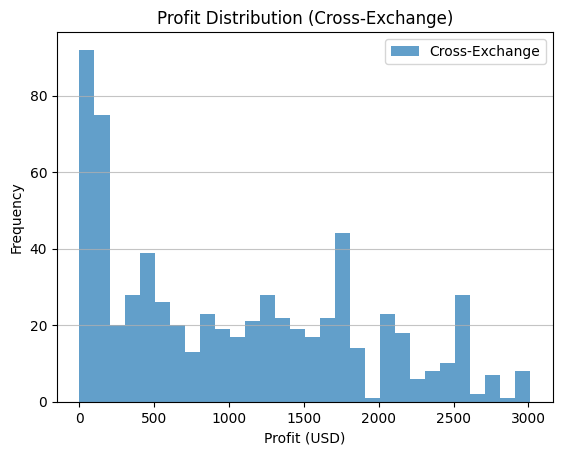


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1887 2024-11-29 10:00:00      0.112488      3.033048          3.030536   
1905 2024-11-29 16:00:00      0.103503      3.033048          3.021551   
1899 2024-11-29 14:00:00      0.100487      3.033048          3.018535   
1884 2024-11-29 09:00:00      0.100414      3.033048          3.018462   
1902 2024-11-29 15:00:00      0.096582      3.033048          3.014630   

       profit_usd                             strategy  
1887  3030.536262  Long Bybit Spot/Short Bybit Futures  
1905  3021.550593  Long Bybit Spot/Short Bybit Futures  
1899  3018.535046  Long Bybit Spot/Short Bybit Futures  
1884  3018.461746  Long Bybit Spot/Short Bybit Futures  
1902  3014.629915  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $737,950.53
Average Profit per Trade (Same-Exchange): $552.36
Max Profit (Same-Exchange): $3,030.54
Simplified Sharpe Rat

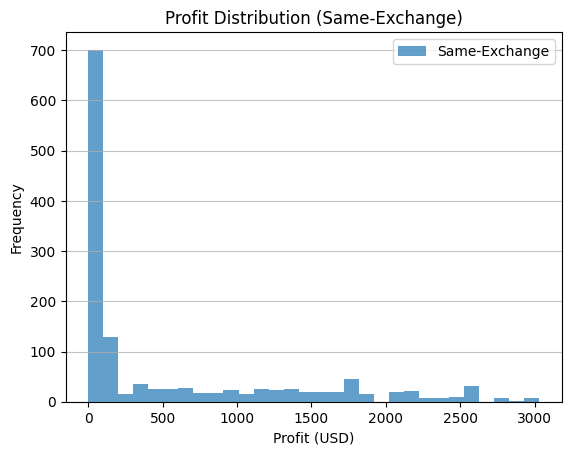


Most Profitable Hour: 1:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0566%
Average Funding Rate: 0.7357%

Position Size: $1,000,000
Found 671 cross-exchange profitable opportunities
Found 1336 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1903 2024-11-29 16:00:00      0.108621      3.033048          3.013169   
1885 2024-11-29 10:00:00      0.105004      3.033048          3.009552   
1882 2024-11-29 09:00:00      0.096217      3.033048          3.000765   
1888 2024-11-29 11:00:00      0.091929      3.033048          2.996477   
1897 2024-11-29 14:00:00      0.091008      3.033048          2.995556   

        profit_usd                               strategy  
1903  30131.694061  Long Binance Spot/Short Bybit Futures  
1885  30095.519130  Long Binance Spot/Short Bybit Futures  
1882  30007.647244  Long Binance Spot/Short Bybit Futures  
1888  29964.77

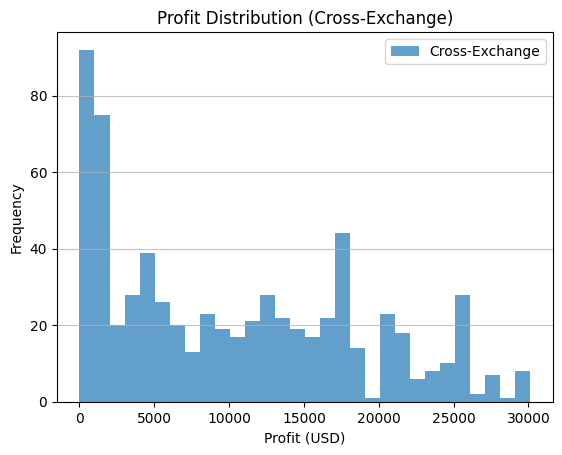


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1887 2024-11-29 10:00:00      0.112488      3.033048          3.030536   
1905 2024-11-29 16:00:00      0.103503      3.033048          3.021551   
1899 2024-11-29 14:00:00      0.100487      3.033048          3.018535   
1884 2024-11-29 09:00:00      0.100414      3.033048          3.018462   
1902 2024-11-29 15:00:00      0.096582      3.033048          3.014630   

        profit_usd                             strategy  
1887  30305.362625  Long Bybit Spot/Short Bybit Futures  
1905  30215.505928  Long Bybit Spot/Short Bybit Futures  
1899  30185.350463  Long Bybit Spot/Short Bybit Futures  
1884  30184.617461  Long Bybit Spot/Short Bybit Futures  
1902  30146.299146  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $7,379,505.31
Average Profit per Trade (Same-Exchange): $5,523.58
Max Profit (Same-Exchange): $30,305.36
Simplified

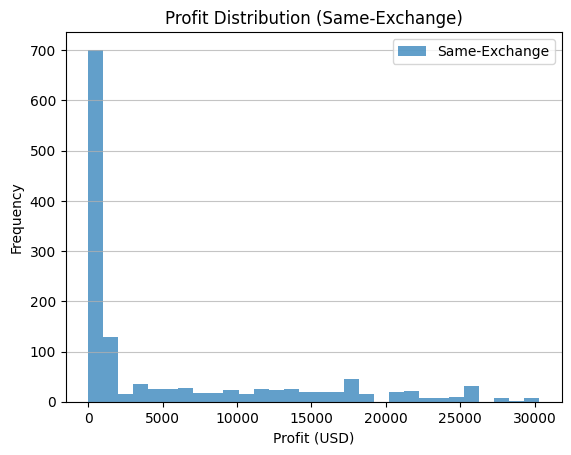


Most Profitable Hour: 1:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0566%
Average Funding Rate: 0.7357%

Position Size: $10,000,000
Found 671 cross-exchange profitable opportunities
Found 1336 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1903 2024-11-29 16:00:00      0.108621      3.033048          3.013169   
1885 2024-11-29 10:00:00      0.105004      3.033048          3.009552   
1882 2024-11-29 09:00:00      0.096217      3.033048          3.000765   
1888 2024-11-29 11:00:00      0.091929      3.033048          2.996477   
1897 2024-11-29 14:00:00      0.091008      3.033048          2.995556   

         profit_usd                               strategy  
1903  301316.940608  Long Binance Spot/Short Bybit Futures  
1885  300955.191299  Long Binance Spot/Short Bybit Futures  
1882  300076.472436  Long Binance Spot/Short Bybit Futures  
1888  299

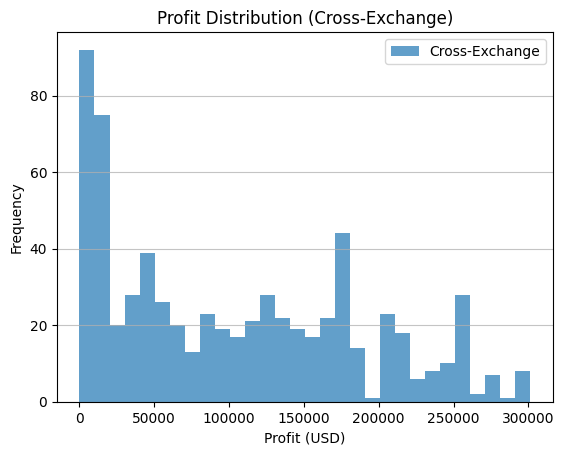


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
1887 2024-11-29 10:00:00      0.112488      3.033048          3.030536   
1905 2024-11-29 16:00:00      0.103503      3.033048          3.021551   
1899 2024-11-29 14:00:00      0.100487      3.033048          3.018535   
1884 2024-11-29 09:00:00      0.100414      3.033048          3.018462   
1902 2024-11-29 15:00:00      0.096582      3.033048          3.014630   

         profit_usd                             strategy  
1887  303053.626246  Long Bybit Spot/Short Bybit Futures  
1905  302155.059278  Long Bybit Spot/Short Bybit Futures  
1899  301853.504633  Long Bybit Spot/Short Bybit Futures  
1884  301846.174615  Long Bybit Spot/Short Bybit Futures  
1902  301462.991461  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $73,795,053.06
Average Profit per Trade (Same-Exchange): $55,235.82
Max Profit (Same-Exchange): $303,053.63
S

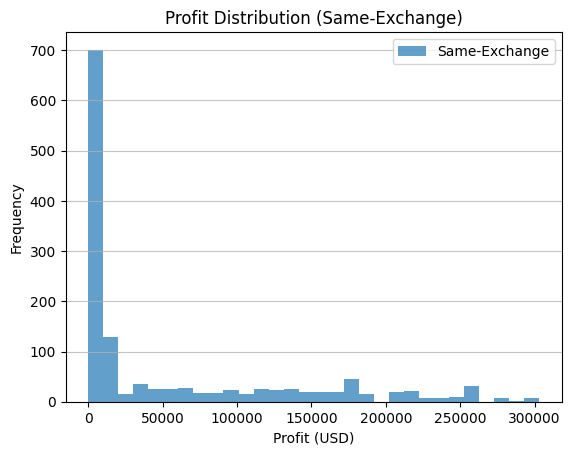


Most Profitable Hour: 1:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0566%
Average Funding Rate: 0.7357%

Analysis for 24-hour holding period:
--------------------------------------------------

Position Size: $100,000
Found 846 cross-exchange profitable opportunities
Found 1427 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2106 2024-11-28 21:00:00      0.118307      7.786922          7.776729   
1638 2024-11-24 23:00:00      0.130398      7.763962          7.765860   
1641 2024-11-25 00:00:00      0.129275      7.763962          7.764737   
2095 2024-11-28 18:00:00      0.097901      7.786922          7.756323   
2092 2024-11-28 17:00:00      0.096548      7.786922          7.754970   

       profit_usd                               strategy  
2106  7776.729058  Long Binance Spot/Short Bybit Futures  
1638  7765.860312  Long Binance Spot/Short Bybit 

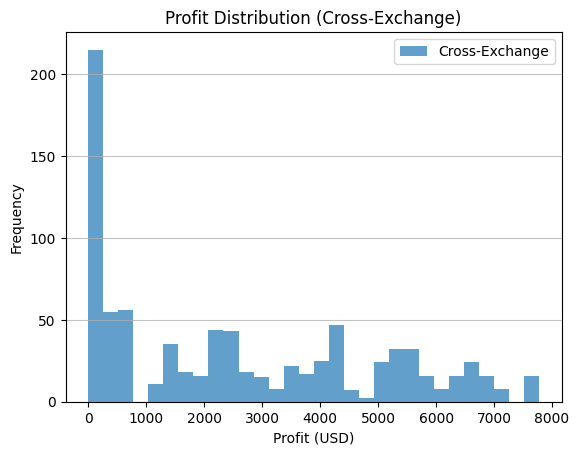


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2109 2024-11-28 21:00:00      0.104139      7.786922          7.776061   
1643 2024-11-25 00:00:00      0.118517      7.763962          7.767479   
2097 2024-11-28 18:00:00      0.089708      7.786922          7.761630   
2101 2024-11-28 19:00:00      0.088382      7.786922          7.760304   
2094 2024-11-28 17:00:00      0.085724      7.786922          7.757646   

       profit_usd                             strategy  
2109  7776.060794  Long Bybit Spot/Short Bybit Futures  
1643  7767.478511  Long Bybit Spot/Short Bybit Futures  
2097  7761.630064  Long Bybit Spot/Short Bybit Futures  
2101  7760.304231  Long Bybit Spot/Short Bybit Futures  
2094  7757.645709  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $2,228,382.87
Average Profit per Trade (Same-Exchange): $1,561.59
Max Profit (Same-Exchange): $7,776.06
Simplified Sharpe

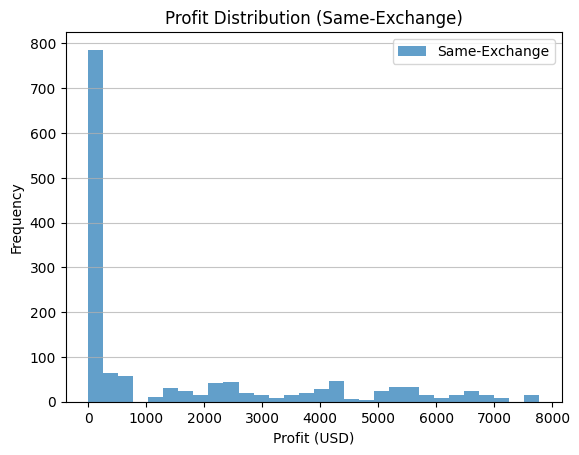


Most Profitable Hour: 2:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0534%
Average Funding Rate: 1.9615%

Position Size: $1,000,000
Found 846 cross-exchange profitable opportunities
Found 1427 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2106 2024-11-28 21:00:00      0.118307      7.786922          7.776729   
1638 2024-11-24 23:00:00      0.130398      7.763962          7.765860   
1641 2024-11-25 00:00:00      0.129275      7.763962          7.764737   
2095 2024-11-28 18:00:00      0.097901      7.786922          7.756323   
2092 2024-11-28 17:00:00      0.096548      7.786922          7.754970   

        profit_usd                               strategy  
2106  77767.290577  Long Binance Spot/Short Bybit Futures  
1638  77658.603124  Long Binance Spot/Short Bybit Futures  
1641  77647.368614  Long Binance Spot/Short Bybit Futures  
2095  77563.22

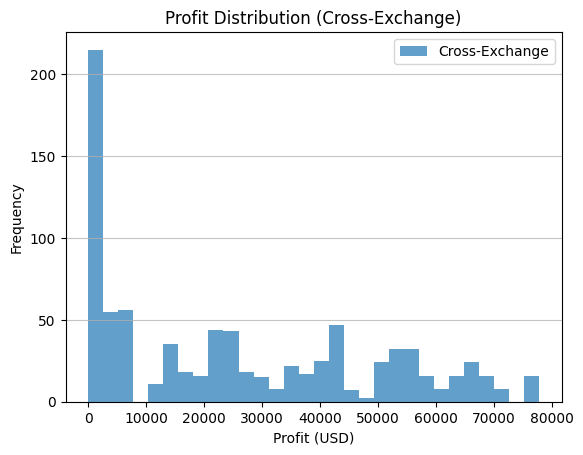


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2109 2024-11-28 21:00:00      0.104139      7.786922          7.776061   
1643 2024-11-25 00:00:00      0.118517      7.763962          7.767479   
2097 2024-11-28 18:00:00      0.089708      7.786922          7.761630   
2101 2024-11-28 19:00:00      0.088382      7.786922          7.760304   
2094 2024-11-28 17:00:00      0.085724      7.786922          7.757646   

        profit_usd                             strategy  
2109  77760.607943  Long Bybit Spot/Short Bybit Futures  
1643  77674.785114  Long Bybit Spot/Short Bybit Futures  
2097  77616.300642  Long Bybit Spot/Short Bybit Futures  
2101  77603.042309  Long Bybit Spot/Short Bybit Futures  
2094  77576.457087  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $22,283,828.67
Average Profit per Trade (Same-Exchange): $15,615.86
Max Profit (Same-Exchange): $77,760.61
Simplifi

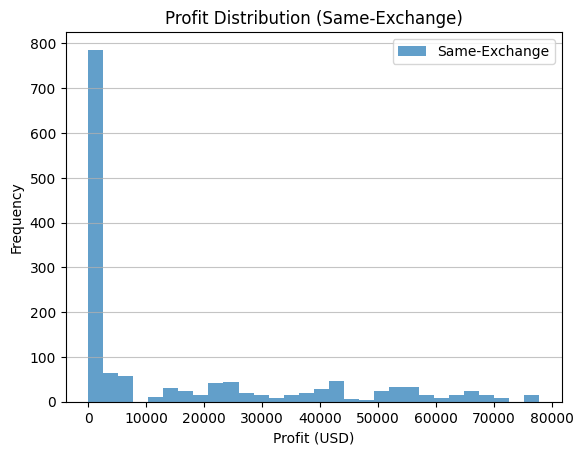


Most Profitable Hour: 2:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0534%
Average Funding Rate: 1.9615%

Position Size: $10,000,000
Found 846 cross-exchange profitable opportunities
Found 1427 same-exchange profitable opportunities

Top 5 Most Profitable Cross-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2106 2024-11-28 21:00:00      0.118307      7.786922          7.776729   
1638 2024-11-24 23:00:00      0.130398      7.763962          7.765860   
1641 2024-11-25 00:00:00      0.129275      7.763962          7.764737   
2095 2024-11-28 18:00:00      0.097901      7.786922          7.756323   
2092 2024-11-28 17:00:00      0.096548      7.786922          7.754970   

         profit_usd                               strategy  
2106  777672.905766  Long Binance Spot/Short Bybit Futures  
1638  776586.031240  Long Binance Spot/Short Bybit Futures  
1641  776473.686136  Long Binance Spot/Short Bybit Futures  
2095  775

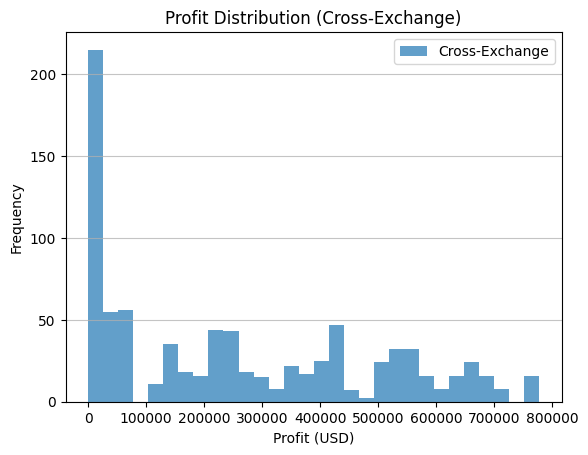


Top 5 Most Profitable Same-Exchange Opportunities:
               timestamp  basis_spread  funding_rate  total_profit_bps  \
2109 2024-11-28 21:00:00      0.104139      7.786922          7.776061   
1643 2024-11-25 00:00:00      0.118517      7.763962          7.767479   
2097 2024-11-28 18:00:00      0.089708      7.786922          7.761630   
2101 2024-11-28 19:00:00      0.088382      7.786922          7.760304   
2094 2024-11-28 17:00:00      0.085724      7.786922          7.757646   

         profit_usd                             strategy  
2109  777606.079425  Long Bybit Spot/Short Bybit Futures  
1643  776747.851137  Long Bybit Spot/Short Bybit Futures  
2097  776163.006421  Long Bybit Spot/Short Bybit Futures  
2101  776030.423091  Long Bybit Spot/Short Bybit Futures  
2094  775764.570868  Long Bybit Spot/Short Bybit Futures  
Total Potential Profit (Same-Exchange): $222,838,286.66
Average Profit per Trade (Same-Exchange): $156,158.58
Max Profit (Same-Exchange): $777,606.08

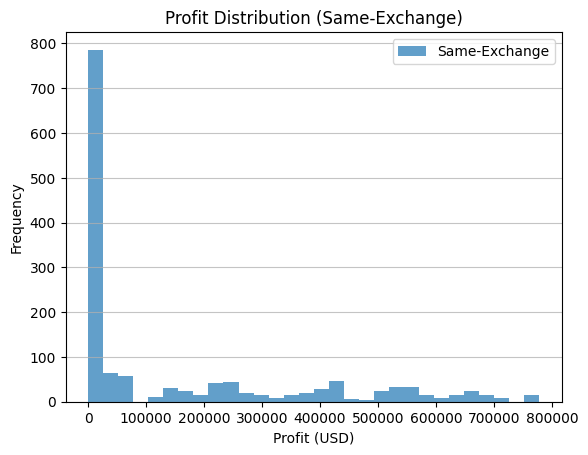


Most Profitable Hour: 2:00 UTC

Profit Component Breakdown:
Average Basis Spread: 0.0534%
Average Funding Rate: 1.9615%


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

class BasisFundingAnalyzer:
    def __init__(self, binance_data, bybit_data, binance_funding, bybit_funding):
        # Initialize price data
        self.binance = binance_data.copy()
        self.bybit = bybit_data.copy()
        self.binance['timestamp'] = pd.to_datetime(self.binance['timestamp'])
        self.bybit['timestamp'] = pd.to_datetime(self.bybit['timestamp'])

        # Initialize funding data
        self.binance_funding = binance_funding.copy()
        self.bybit_funding = bybit_funding.copy()
        self.binance_funding['time'] = pd.to_datetime(self.binance_funding['time'])
        self.bybit_funding['time'] = pd.to_datetime(self.bybit_funding['time'])

        # Best tier fees (VIP9/VIP3)
        self.fees = {
            'binance': {
                'spot_maker': 0.0,
                'futures_taker': 0.000135,
            },
            'bybit': {
                'spot_maker': 0.0007,
                'futures_taker': 0.00045
            }
        }

    def get_funding_rate(self, timestamp, exchange, holding_period_hours=8):
      """Calculate accumulated funding for a given period"""
      end_time = timestamp + timedelta(hours=holding_period_hours)

      if exchange == 'binance':
        funding_data = self.binance_funding[
              (self.binance_funding['time'] >= timestamp) &
              (self.binance_funding['time'] < end_time)
          ]
        return funding_data['fundingRate'].astype(float).sum() * 100  # Convert to percentage
      else:
        funding_data = self.bybit_funding[
            (self.bybit_funding['time'] >= timestamp) &
              (self.bybit_funding['time'] < end_time)
          ]
        return funding_data['fundingRate'].astype(float).sum() * 100

    def _calculate_opportunity(self, row, min_position_size, holding_period_hours):
        timestamp = row['timestamp']

        # Calculate basis spreads
        binance_spot_bybit_futures = (
            row['close_futures_bybit'] - row['close_spot_binance']
        ) / row['close_spot_binance'] * 100

        bybit_spot_binance_futures = (
            row['close_futures_binance'] - row['close_spot_bybit']
        ) / row['close_spot_bybit'] * 100
      
        binance_basis = (row['close_futures_binance'] - row['close_spot_binance'])/row['close_spot_binance'] * 100
        bybit_basis = (row['close_futures_bybit'] - row['close_spot_bybit'])/row['close_spot_bybit'] * 100

        # Get funding rates
        binance_funding = self.get_funding_rate(timestamp, 'binance', holding_period_hours)
        bybit_funding = self.get_funding_rate(timestamp, 'bybit', holding_period_hours)

        # Calculate trading costs
        cross_exchange_cost = (
          (self.fees['binance']['spot_maker'] + self.fees['binance']['futures_taker'] +
            self.fees['bybit']['spot_maker'] + self.fees['bybit']['futures_taker']) * 100
        )
        binance_cost = (self.fees['binance']['spot_maker'] + self.fees['binance']['futures_taker']) * 100
        bybit_cost = (self.fees['bybit']['spot_maker'] + self.fees['bybit']['futures_taker']) * 100
        
        opportunities = []

        # Cross-exchange opportunities
        # Strategy 1: Long Binance Spot, Short Bybit Futures
        profit1 = abs(binance_spot_bybit_futures) + bybit_funding - cross_exchange_cost
        if profit1 > 0:
          opportunities.append({
              'timestamp': timestamp,
              'basis_spread': binance_spot_bybit_futures,
              'funding_rate': bybit_funding,
              'total_profit_bps': profit1,
              'profit_usd': (profit1 * min_position_size) / 100,
              'strategy': 'Long Binance Spot/Short Bybit Futures',
              'binance_spot': row['close_spot_binance'],
              'bybit_futures': row['close_futures_bybit'],
              'type': 'cross-exchange'
          })
        
        # Strategy 2: Long Bybit Spot, Short Binance Futures
        profit2 = abs(bybit_spot_binance_futures) + binance_funding - cross_exchange_cost
        if profit2 > 0:
          opportunities.append({
                'timestamp': timestamp,
                'basis_spread': bybit_spot_binance_futures,
                'funding_rate': binance_funding,
                'total_profit_bps': profit2,
                'profit_usd': (profit2 * min_position_size) / 100,
                'strategy': 'Long Bybit Spot/Short Binance Futures',
                'binance_futures': row['close_futures_binance'],
                'bybit_spot': row['close_spot_bybit'],
                'type': 'cross-exchange'
            })


        # Same-exchange opportunities
        # Strategy 3: Long Binance Spot, Short Binance Futures
        profit3 = abs(binance_basis) + binance_funding - binance_cost
        if profit3 > 0:
            opportunities.append({
                'timestamp': timestamp,
                'basis_spread': binance_basis,
                'funding_rate': binance_funding,
                'total_profit_bps': profit3,
                'profit_usd': (profit3 * min_position_size) / 100,
                'strategy': 'Long Binance Spot/Short Binance Futures',
                'binance_spot': row['close_spot_binance'],
                'binance_futures': row['close_futures_binance'],
                'type': 'same-exchange (binance)'
            })
            
        # Strategy 4: Long Bybit Spot, Short Bybit Futures
        profit4 = abs(bybit_basis) + bybit_funding - bybit_cost
        if profit4 > 0:
            opportunities.append({
                'timestamp': timestamp,
                'basis_spread': bybit_basis,
                'funding_rate': bybit_funding,
                'total_profit_bps': profit4,
                'profit_usd': (profit4 * min_position_size) / 100,
                'strategy': 'Long Bybit Spot/Short Bybit Futures',
                'bybit_spot': row['close_spot_bybit'],
                'bybit_futures': row['close_futures_bybit'],
                'type': 'same-exchange (bybit)'
            })
        
        return opportunities
            


    def find_opportunities(self, min_position_size=1000000, holding_period_hours=8):
        """Find arbitrage opportunities, including both cross and same exchange"""
        # Merge price data
        merged = pd.merge(
            self.binance,
            self.bybit,
            on='timestamp',
            suffixes=('_binance', '_bybit')
        )
        
        all_opportunities = []

        for _, row in merged.iterrows():
          opportunities = self._calculate_opportunity(row, min_position_size, holding_period_hours)
          all_opportunities.extend(opportunities)


        return pd.DataFrame(all_opportunities)


def main():
    # Load data
    binance_data = pd.read_csv('/tmp/binance_basis.csv')
    bybit_data = pd.read_csv('/tmp/bybit_basis.csv')
    binance_funding = pd.read_csv('/tmp/binance_funding_rates.csv')
    bybit_funding = pd.read_csv('/tmp/bybit_funding_rates.csv')

    # Initialize analyzer
    analyzer = BasisFundingAnalyzer(
        binance_data,
        bybit_data,
        binance_funding,
        bybit_funding
    )

    # Analyze different holding periods
    holding_periods = [8, 24]  # hours
    position_sizes = [100000, 1000000, 10000000]
    
    for period in holding_periods:
        print(f"\nAnalysis for {period}-hour holding period:")
        print("-" * 50)
        
        for size in position_sizes:
            opportunities = analyzer.find_opportunities(
                min_position_size=size,
                holding_period_hours=period
            )
            
            print(f"\nPosition Size: ${size:,}")
            
            if not opportunities.empty:

                # Separate cross-exchange and same-exchange opportunities
                cross_exchange_ops = opportunities[opportunities['type'] == 'cross-exchange']
                same_exchange_ops = opportunities[opportunities['type'].str.startswith('same-exchange')]
                
                print(f"Found {len(cross_exchange_ops)} cross-exchange profitable opportunities")
                print(f"Found {len(same_exchange_ops)} same-exchange profitable opportunities")

                # Calculate metrics
                def analyze_opportunity_type(ops, name):
                    if not ops.empty:
                        print(f"\nTop 5 Most Profitable {name} Opportunities:")
                        print(ops.nlargest(5, 'total_profit_bps')[
                            ['timestamp', 'basis_spread', 'funding_rate', 'total_profit_bps', 'profit_usd', 'strategy']
                        ])
                        print(f"Total Potential Profit ({name}): ${ops['profit_usd'].sum():,.2f}")
                        print(f"Average Profit per Trade ({name}): ${ops['profit_usd'].mean():,.2f}")
                        print(f"Max Profit ({name}): ${ops['profit_usd'].max():,.2f}")
                         # Calculate simplified Sharpe Ratio
                        mean_profit = ops['profit_usd'].mean()
                        std_profit = ops['profit_usd'].std()
                        if std_profit > 0:
                           sharpe_ratio = mean_profit / std_profit
                        else:
                           sharpe_ratio = 0  #Handle case when there are no profitable trades or std_profit = 0
                        print(f"Simplified Sharpe Ratio ({name}): {sharpe_ratio:.4f}")

                        # Calculate simplified Max Drawdown
                        cumulative_profits = ops['profit_usd'].cumsum()
                        max_so_far = cumulative_profits.cummax()
                        drawdown = max_so_far - cumulative_profits
                        max_drawdown = drawdown.max()
                        print(f"Simplified Max Drawdown ({name}): ${max_drawdown:,.2f}")
                         # Plot profit distribution
                        plt.figure()
                        plt.hist(ops['profit_usd'], bins=30, alpha=0.7, label=name)
                        plt.title(f"Profit Distribution ({name})")
                        plt.xlabel("Profit (USD)")
                        plt.ylabel("Frequency")
                        plt.legend()
                        plt.grid(axis='y', alpha=0.75)
                        plt.show()

                    else:
                        print(f"No {name} profitable opportunities found")

                analyze_opportunity_type(cross_exchange_ops, "Cross-Exchange")
                analyze_opportunity_type(same_exchange_ops, "Same-Exchange")

                opportunities['hour'] = opportunities['timestamp'].dt.hour
                hourly_stats = opportunities.groupby('hour')['total_profit_bps'].mean()
                best_hour = hourly_stats.idxmax()
                print(f"\nMost Profitable Hour: {best_hour}:00 UTC")

                # Profit breakdown
                print("\nProfit Component Breakdown:")
                print(f"Average Basis Spread: {opportunities['basis_spread'].mean():.4f}%")
                print(f"Average Funding Rate: {opportunities['funding_rate'].mean():.4f}%")
            else:
                print("No opportunities found.")

if __name__ == "__main__":
    main()